In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 0.05           # rate Is -> Q



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ia0 = np.array([0, 0])     
Is0 = np.array([0, 0])     
Q0  = np.array([0, 0])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

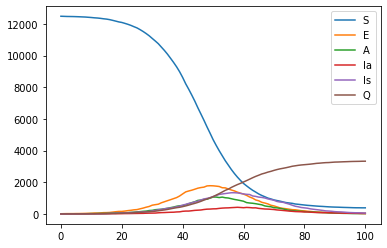

In [4]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.plot(data_array[:, 5*M], label='Q')

plt.legend()
plt.show()

# Infer parameters based on part of the trajectory

In [29]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x[:,:8*M]/N)[:Nf_inference]
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

det_model = pyross.deterministic.SEAIRQ(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)

In [30]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-922.5914879387894
0.20755696296691895


In [31]:
eps = 1e-4 

alpha_g = 0.3
alpha_bounds = (0.1, 0.5)
beta_g = 0.1
beta_bounds = (eps, 0.1)
gIa_g = 0.2 
gIa_bounds = (eps, 0.5)
gIs_g = 0.2 
gIs_bounds = (0.13, 0.15)
gE_g = 0.2
gE_bounds = (0.1, 0.3)
gA_g = 0.5 
gA_bounds = (0.25, 0.75)


guess = [alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]
bounds = [alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, gA_bounds]
params, nit = estimator.inference(guess, x, Tf_inference, Nf_inference, contactMatrix, 
                                  bounds, niter=4, ftol=1e-6, eps=eps, verbose=False)

print('best estimates: ', params)
print('no. of iterations: ', nit)

best estimates:  [0.24651927 0.02058536 0.19393321 0.13       0.19316908 0.3187826 ]
no. of iterations:  4


In [32]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = estimator.make_params_dict(params)
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-926.1784569158519
0.20496606826782227


In [33]:
hessian = estimator.hessian(params,x,Tf_inference,Nf_inference,contactMatrix)
cov = np.linalg.inv(hessian)
#cov

# Compare forecast based on inferred parameters to full trajectory

In [34]:
parameters = {'alpha':params[0], 'beta':params[1],
              'gIa':params[2], 'gIs':params[3],
              'gE':params[4],'gA':params[5],
               'fsa':fsa,
             'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs,
             'cov':cov
                }

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAIRQ(parameters, M, Ni)

In [35]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[-1,:M]*N
E0_forecast = x[-1,M:2*M]*N
A0_forecast = x[-1,2*M:3*M]*N
Ia0_forecast = x[-1,3*M:4*M]*N
Is0_forecast = x[-1,4*M:5*M]*N
Q0_forecast = x[-1,5*M:6*M]*N


# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, E0_forecast, A0_forecast,Ia0_forecast,
                                           Is0_forecast, Q0_forecast,
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                          method='tau-leaping',
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

Finished. Time needed for evaluation: 00:00:42


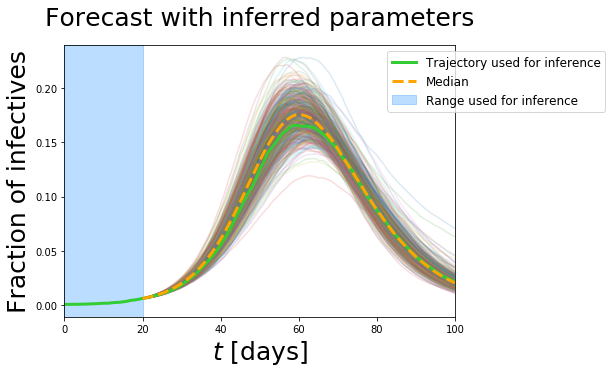

In [36]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show(fig)
#fig.savefig('inference_and_forecasting_SEAIRQ.png',bbox_inches='tight',dpi=100)
plt.close(fig)